<a href="https://colab.research.google.com/github/Phoenix23111/Advanced_AI_Assignment/blob/master/Advanced_AI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

In [9]:
# SETTINGS
BATCH_SIZE = 128
EPOCHS = 3
LR = 1e-3
MIXUP_ALPHA = 0.3
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Source domains (TRAINING)
mnist_train = datasets.MNIST("data", train=True, download=True, transform=transform)
fmnist_train = datasets.FashionMNIST("data", train=True, download=True, transform=transform)

# Target domains (TEST — UNSEEN)
mnist_test = datasets.MNIST("data", train=False, download=True, transform=transform)
fmnist_test = datasets.FashionMNIST("data", train=False, download=True, transform=transform)
kmnist_test = datasets.KMNIST("data", train=False, download=True, transform=transform)

# Combine only MNIST + FashionMNIST for training
train_dataset = ConcatDataset([mnist_train, fmnist_train])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Separate test loaders
test_loaders = {
    "MNIST": DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False),
    "FashionMNIST": DataLoader(fmnist_test, batch_size=BATCH_SIZE, shuffle=False),
    "KMNIST (Unseen)": DataLoader(kmnist_test, batch_size=BATCH_SIZE, shuffle=False)
}

print(f"Train size: {len(train_dataset)}")
print(f"MNIST test: {len(mnist_test)}, FashionMNIST test: {len(fmnist_test)}, KMNIST test: {len(kmnist_test)}")


Train size: 120000
MNIST test: 10000, FashionMNIST test: 10000, KMNIST test: 10000


In [11]:

# MODEL: ResNet18 adapted for 1-channel input

def get_resnet18(num_classes=10, pretrained=False):
    model = models.resnet18(weights=None if not pretrained else models.ResNet18_Weights.DEFAULT)
    # change first conv to accept 1 channel
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# quick sanity
test_model = get_resnet18()
print(test_model)
del test_model


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# MIXUP helpers
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        return x, y, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam*x + (1-lam)*x[index]
    return mixed_x, y, y[index], lam

def mixup_criterion(pred, y_a, y_b, lam, crit):
    return lam*crit(pred, y_a) + (1-lam)*crit(pred, y_b)



In [13]:
# TRAIN & EVAL functions
def train_one_epoch(model, loader, optimizer, criterion, use_mixup=False):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        if use_mixup:
            x_m, y_a, y_b, lam = mixup_data(x, y)
            out = model(x_m)
            loss = mixup_criterion(out, y_a, y_b, lam, criterion)
            preds = out.argmax(1)
        else:
            out = model(x)
            loss = criterion(out, y)
            preds = out.argmax(1)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()*x.size(0)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss/total, correct/total

def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)

            correct += (preds == y).sum().item()
            total += y.size(0)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    return correct/total, np.concatenate(all_preds), np.concatenate(all_labels)



In [14]:
# TRAINING PIPELINE that runs ERM and Mixup experiments
def run_experiment(use_mixup=False):
    print("\nRunning:", "Mixup" if use_mixup else "ERM")
    model = get_resnet18()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    history = {"loss": [], "acc": []}

    for ep in range(EPOCHS):
        loss, acc = train_one_epoch(model, train_loader, optimizer, criterion, use_mixup)
        history["loss"].append(loss)
        history["acc"].append(acc)
        print(f"Epoch {ep+1}/{EPOCHS} — Loss={loss:.4f}, Acc={acc*100:.2f}%")

    results = {}
    preds_dict, labels_dict = {}, {}

    for name, loader in test_loaders.items():
        acc, preds, labels = evaluate(model, loader)
        results[name] = acc
        preds_dict[name] = preds
        labels_dict[name] = labels
        print(f"{name} Accuracy = {acc*100:.2f}%")

    return model, history, results, preds_dict, labels_dict

# =============================
# RUN BOTH EXPERIMENTS
# =============================
erm_model, erm_hist, erm_results, erm_preds, erm_labels = run_experiment(use_mixup=False)
mix_model, mix_hist, mix_results, mix_preds, mix_labels = run_experiment(use_mixup=True)



Running: ERM
Epoch 1/3 — Loss=0.2792, Acc=90.24%
Epoch 2/3 — Loss=0.1490, Acc=94.73%
Epoch 3/3 — Loss=0.1237, Acc=95.63%
MNIST Accuracy = 98.90%
FashionMNIST Accuracy = 91.05%
KMNIST (Unseen) Accuracy = 10.79%

Running: Mixup
Epoch 1/3 — Loss=0.7058, Acc=48.76%
Epoch 2/3 — Loss=0.5287, Acc=54.63%
Epoch 3/3 — Loss=0.4865, Acc=52.26%
MNIST Accuracy = 99.08%
FashionMNIST Accuracy = 91.76%
KMNIST (Unseen) Accuracy = 8.27%


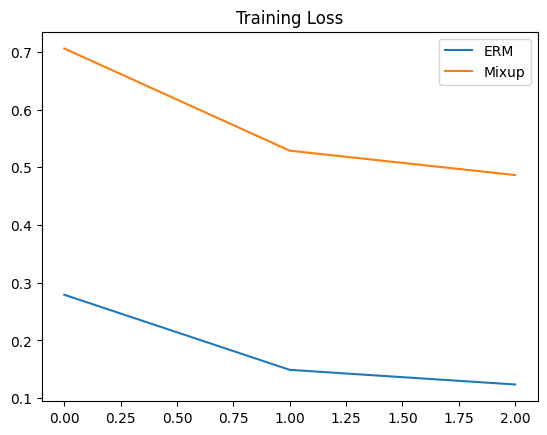

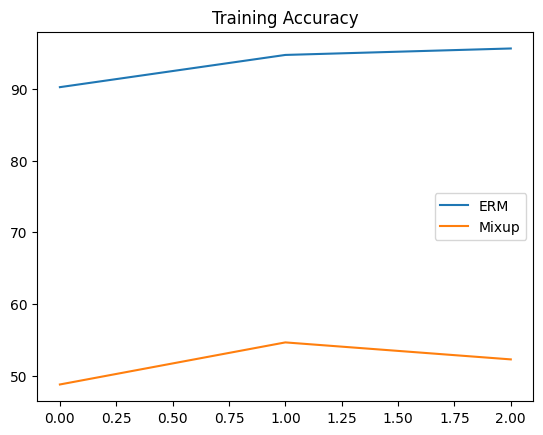

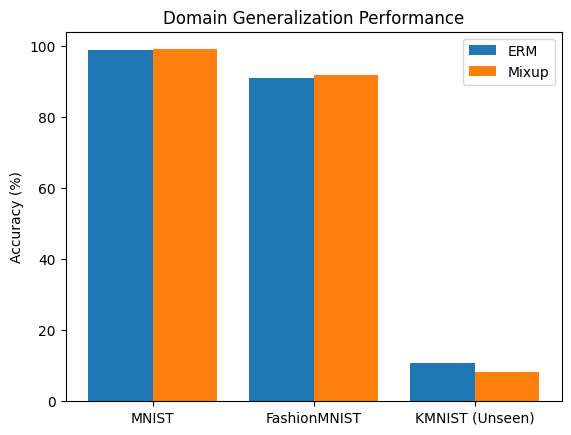

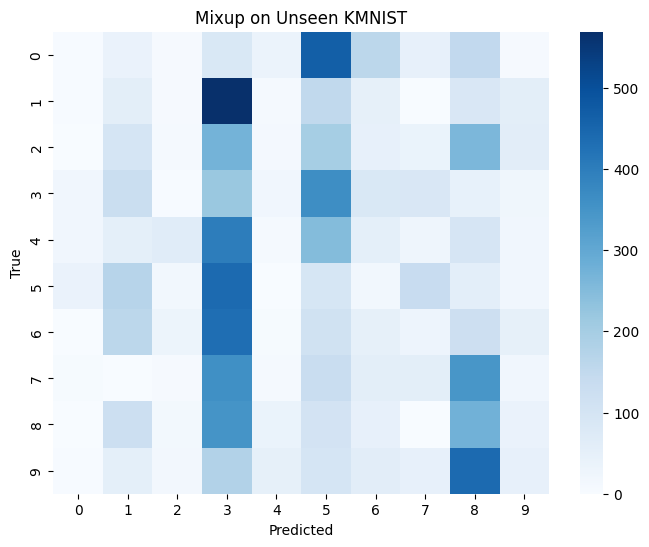

In [15]:
# PLOTTING: loss & accuracy curves and per-domain comparisonw
# PLOTTING

plt.plot(erm_hist["loss"], label="ERM")
plt.plot(mix_hist["loss"], label="Mixup")
plt.title("Training Loss")
plt.legend()
plt.show()

plt.plot([a*100 for a in erm_hist["acc"]], label="ERM")
plt.plot([a*100 for a in mix_hist["acc"]], label="Mixup")
plt.title("Training Accuracy")
plt.legend()
plt.show()

# =============================
# BAR CHART — Domain Accuracy
# =============================
domains = list(test_loaders.keys())
x = np.arange(len(domains))

erm_acc = [erm_results[d]*100 for d in domains]
mix_acc = [mix_results[d]*100 for d in domains]

plt.bar(x-0.2, erm_acc, 0.4, label="ERM")
plt.bar(x+0.2, mix_acc, 0.4, label="Mixup")
plt.xticks(x, domains)
plt.ylabel("Accuracy (%)")
plt.title("Domain Generalization Performance")
plt.legend()
plt.show()

# =============================
# CONFUSION MATRIX — KMNIST
# =============================
target = "KMNIST (Unseen)"
cm = confusion_matrix(mix_labels[target], mix_preds[target])

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues")
plt.title("Mixup on Unseen KMNIST")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

